In [3]:
# first check the wd
# this should be AIggregation folder

import os
os.getcwd()

#os.chdir("..")


'/home/tmueller/github/AIggregation'

 100% |█████████████████████| 1/1 [40.0ms elapsed, 0s remaining, 25.9 samples/s] 



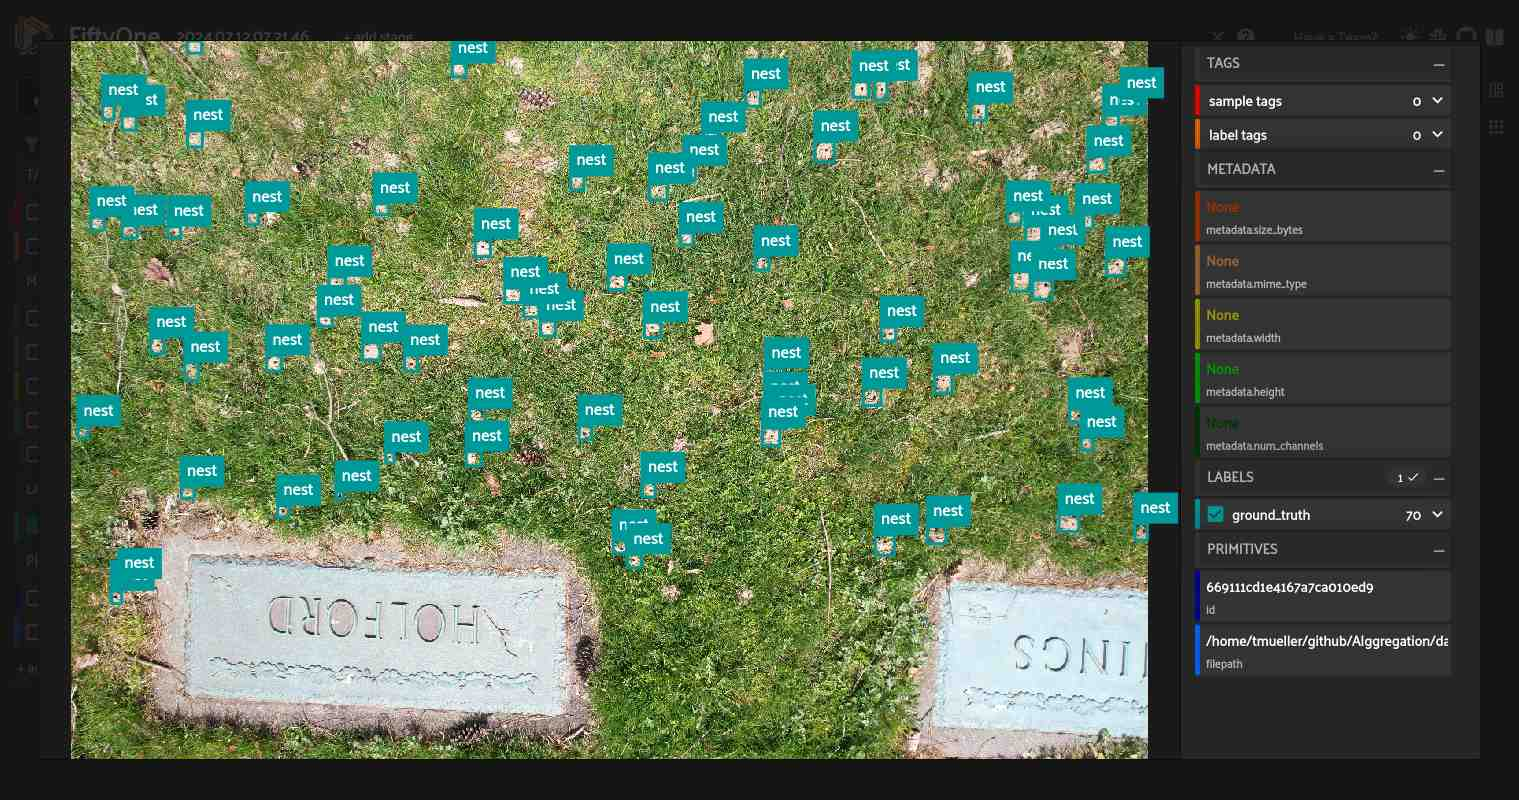

In [4]:


#now import fiftyone
import fiftyone as fo
from fiftyone import ViewField as F



# Import annotated test image into fiftyone dataset type
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/test_image/test.yaml"
)

# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)



In [5]:
# import required sahi functions
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict

os.getcwd()


# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)


# do a simple yolo prediction without slicing
# only on the first image in the dataset
result = get_prediction(dataset.first().filepath, detection_model)


# now do sliced prediction with sahi
sliced_result = get_sliced_prediction(
    dataset.first().filepath,
    detection_model,
    slice_height = 608,
    slice_width = 608,
    overlap_height_ratio = 0.1,
    overlap_width_ratio = 0.1
)


# compare number of detections with and without slicing just for fun
num_sliced_dets = len(sliced_result.to_fiftyone_detections())
num_orig_dets = len(result.to_fiftyone_detections())

print(f"Detections predicted without slicing: {num_orig_dets}")
print(f"Detections predicted with slicing: {num_sliced_dets}")




/home/tmueller/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Performing prediction on 70 slices.
Detections predicted without slicing: 10
Detections predicted with slicing: 81


 100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 


07/12/2024 07:38:39 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 


Evaluating detections...


07/12/2024 07:38:40 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████████| 1/1 [615.6ms elapsed, 0s remaining, 1.6 samples/s] 


07/12/2024 07:38:40 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [615.6ms elapsed, 0s remaining, 1.6 samples/s] 


Evaluating detections...


07/12/2024 07:38:41 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████████| 1/1 [757.1ms elapsed, 0s remaining, 1.3 samples/s] 


07/12/2024 07:38:41 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [757.1ms elapsed, 0s remaining, 1.3 samples/s] 


Evaluating detections...


07/12/2024 07:38:41 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████████| 1/1 [630.0ms elapsed, 0s remaining, 1.6 samples/s] 


07/12/2024 07:38:42 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [630.0ms elapsed, 0s remaining, 1.6 samples/s] 


--------------------------------------------------
Large slice results:
              precision    recall  f1-score   support

        nest       0.67      0.89      0.77        70

   micro avg       0.67      0.89      0.77        70
   macro avg       0.67      0.89      0.77        70
weighted avg       0.67      0.89      0.77        70

--------------------------------------------------
Large slice overlap results:
              precision    recall  f1-score   support

        nest       0.69      0.89      0.78        70

   micro avg       0.69      0.89      0.78        70
   macro avg       0.69      0.89      0.78        70
weighted avg       0.69      0.89      0.78        70

--------------------------------------------------
Small slice results:
              precision    recall  f1-score   support

        nest       0.53      0.89      0.67        70

   micro avg       0.53      0.89      0.67        70
   macro avg       0.53      0.89      0.67        70
weighted avg


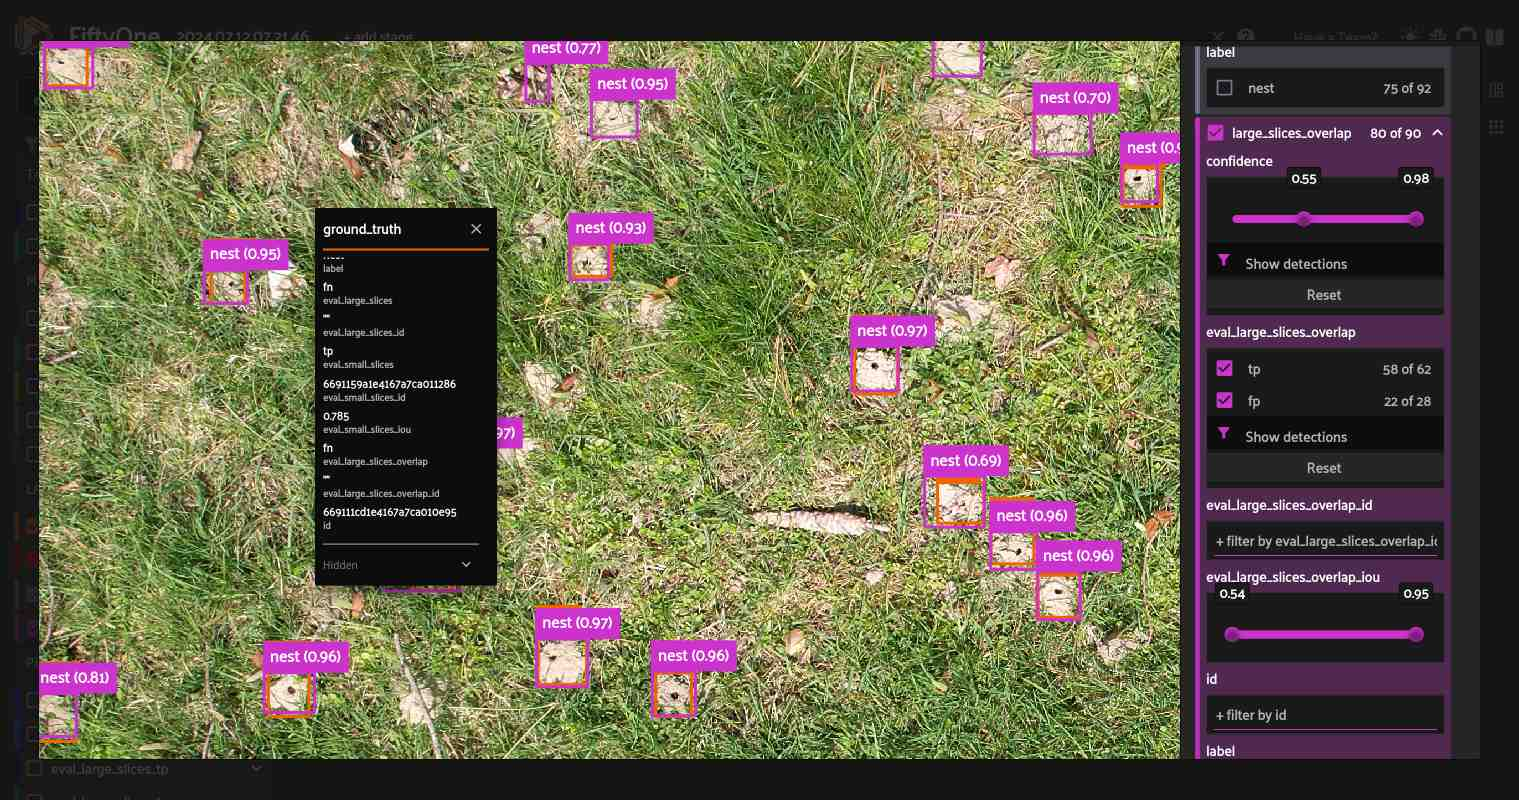

In [12]:



# Now to run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample, label_field="small_slices", slice_height=304, slice_width=304, overlap_height_ratio = .2, overlap_width_ratio=.2, **kwargs)
    predict_with_slicing(sample, label_field="large_slices", slice_height=608, slice_width=608, overlap_height_ratio = .2, overlap_width_ratio=.2,  **kwargs)
    predict_with_slicing(sample, label_field="large_slices_overlap", slice_height=608, slice_width=608, overlap_height_ratio = .4, overlap_width_ratio=.4,  **kwargs)





# evaluate the different sahi predictions
large_slice_results = dataset.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = dataset.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = dataset.evaluate_detections("large_slices_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")

# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()



#bring up new session to see boxes
session.show()




In [15]:
# now show images where sahi is labeling false positives
# check if ground_truth labels needs to be adjusted
# for instance in this very quickly annotated test image - AI is probably outperforming me to a degree...


high_conf_fp_view = dataset.to_evaluation_patches(eval_key="eval_large_slices_overlap").match(F("type")=="fp").sort_by("large_slices_overlap.detection.confidence")

session.view = high_conf_fp_view.view()